# GraphSAGE

* PubMed数据集(引文网络)包括来自Pubmed数据库的19717篇关于糖尿病的科学出版物，分为三类：
* 引文网络由44338个链接组成。数据集中的每个出版物都由一个由500个唯一单词组成的字典中的TF/IDF加权词向量来描述。

In [276]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import re
from jupyterthemes import jtplot
jtplot.style()
from tqdm import tqdm

In [186]:
import random

In [189]:
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [340]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers

In [339]:
%load_ext tensorboard

In [3]:
# 需要的全局参数
config = {
    'n_neighbor_list': [6, 6, 8],
    'out_dim_list': [128, 64, 16],
    'n_class': 3,
    'in_dim': 500
}

# Loading

## Paper Vector

In [2]:
# 文章特征向量
with open('./data/Pubmed-Diabetes.NODE.paper.tab', 'r') as f:
    _, meta_data, *contents = f.readlines()
    
# 构造 DataFrame 的列
words = [re.findall(':(.*):0.0', x)[0] for x in meta_data.split('\t')[1:-1]]

# 构造 record 数据形式
record = []
for content in contents:
    paper_id, label, *words_vec, _ = content.split('\t')
    
    record.append({
        'paper_id': int(paper_id),
        'label': int(label.split('=')[1])-1,
        **dict([x.split('=') for x in words_vec]),
    })

# 构造 DataFrame 
df_paper = pd.DataFrame(data=record, columns=['paper_id', 'label', *words])
df_paper.fillna(0.0, inplace=True)

# 转浮点数
df_paper[words] = df_paper[words].astype('float')
df_paper

,paper_id,label,w-rat,w-common,w-use,w-examin,w-pathogenesi,w-retinopathi,w-mous,w-studi,...,w-kidney,w-urinari,w-myocardi,w-meal,w-ica,w-locus,w-tcell,w-depress,w-bone,w-mutat
0,12187484,0,0.093935,0.028698,0.011760,0.019375,0.063161,0.170891,0.067702,0.017555,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2344352,0,0.023618,0.000000,0.014784,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,14654069,0,0.102263,0.000000,0.010669,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,16443886,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2684155,0,0.030616,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19712,17559889,2,0.000000,0.000000,0.022998,0.000000,0.000000,0.000000,0.000000,0.022886,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19713,8792097,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008728,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19714,17934141,0,0.067942,0.000000,0.014177,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19715,18673544,2,0.000000,0.000000,0.009240,0.000000,0.000000,0.000000,0.000000,0.009195,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Cites Relations

In [3]:
# 引用关系
with open('./data/Pubmed-Diabetes.DIRECTED.cites.tab', 'r') as f:
    meta_data, _, *cites = f.readlines()

record = []
for cite in cites:
    idx, paper1, _, paper2 = cite.split('\t')
    record.append({
        'idx': int(idx),
        'paper1': int(paper1.split(':')[1]),
        'paper2': int(paper2.split(':')[1])
    })
    
df_cites = pd.DataFrame(data=record, columns=['idx', 'paper1', 'paper2'])
df_cites

,idx,paper1,paper2
0,33824,19127292,17363749
1,37511,19668377,17293876
2,6735,1313726,3002783
3,33493,19110882,14578298
4,27380,18606979,10333910
...,...,...,...
44333,29574,18776148,1473616
44334,38877,2040701,3894118
44335,32411,19036853,10864585
44336,21402,18078023,15270789


## Index Mapping

In [4]:
# 文章到索引映射
paper2idx = {paper: idx for paper, idx in zip(df_paper['paper_id'].unique(), range(len(df_paper)))}
df_paper['idx'] = df_paper['paper_id'].apply(lambda x: paper2idx[x])
df_cites['paper1'] = df_cites['paper1'].apply(lambda x: paper2idx[x])
df_cites['paper2'] = df_cites['paper2'].apply(lambda x: paper2idx[x])

In [5]:
df_paper.head()

,paper_id,label,w-rat,w-common,w-use,w-examin,w-pathogenesi,w-retinopathi,w-mous,w-studi,...,w-urinari,w-myocardi,w-meal,w-ica,w-locus,w-tcell,w-depress,w-bone,w-mutat,idx
0,12187484,0,0.093935,0.028698,0.011760,0.019375,0.063161,0.170891,0.067702,0.017555,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2344352,0,0.023618,0.000000,0.014784,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,14654069,0,0.102263,0.000000,0.010669,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,16443886,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,2684155,0,0.030616,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [6]:
df_cites.head()

,idx,paper1,paper2
0,33824,10816,18459
1,37511,8069,3834
2,6735,297,16724
3,33493,8613,10896
4,27380,9238,12701


# Data Distribution

## Label

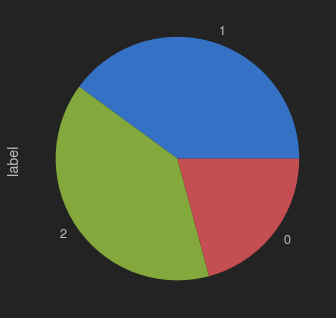

In [7]:
# 标签比例
df_paper['label'].value_counts().plot(kind='pie')
plt.show()

## Cites

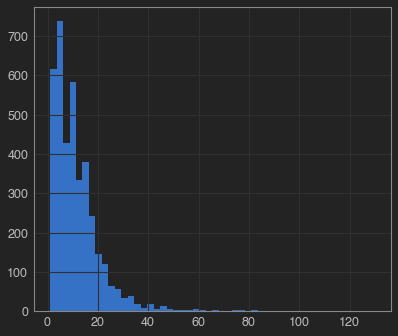

In [8]:
# 引用分布
df_cites['paper1'].value_counts().hist(bins=50)
plt.show()

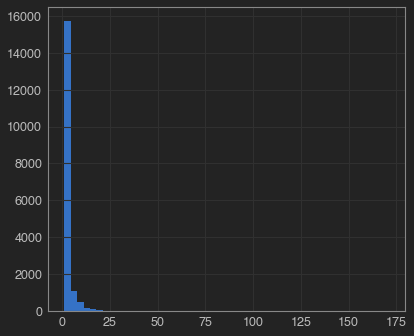

In [9]:
# 引用分布
df_cites['paper2'].value_counts().hist(bins=50)
plt.show()

## Features

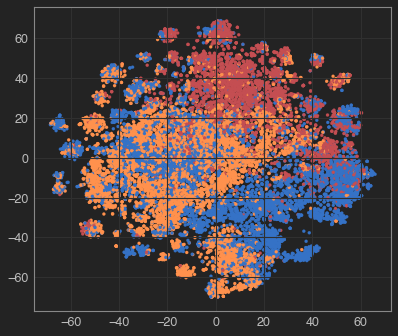

In [10]:
# 可视化词向量
tsne = TSNE(n_components=2, init='pca', random_state=501)
x_tsne = tsne.fit_transform(df_paper[words].values)

c_map = {0: 'r', 1: 'b', 2: 'y'}
plt.scatter(x_tsne[:,0], x_tsne[:,1], c=[c_map[x] for x in df_paper['label'].values], s=10)
plt.show()

# Split Data

## Nodes

In [12]:
size = 0.2
random.seed(529)

train_nodes, vaild_nodes = [], []

for idx in df_paper['idx'].values.tolist():
    if random.random() >= size:
        train_nodes.append(idx)
    else:
        vaild_nodes.append(idx)
        
len(train_nodes), len(vaild_nodes)

(15871, 3846)

## Train & Vaild

In [13]:
x_train = df_paper[df_paper['idx'].isin(train_nodes)][words]
y_train = df_paper[df_paper['idx'].isin(train_nodes)][['label']]
x_vaild = df_paper[df_paper['idx'].isin(vaild_nodes)][words]
y_vaild = df_paper[df_paper['idx'].isin(vaild_nodes)][['label']]

x_train.shape, y_train.shape, x_vaild.shape, y_vaild.shape

((15871, 500), (15871, 1), (3846, 500), (3846, 1))

## Train SubGraph

In [192]:
# 提取只有训练集节点的引用关系，保证不出现验证集的节点，可能会少了一些 train_nodes
df_sub_cites = df_cites[(df_cites['paper1'].isin(train_nodes)) & (df_cites['paper2'].isin(train_nodes))]

# 构造训练集的图
train_G = nx.Graph()
train_G.add_edges_from(df_sub_cites[['paper1', 'paper2']].values.tolist())

len(train_G.nodes), len(train_G.edges)

(14286, 28467)

# BaseLine

## LogisticRegression

In [337]:
lr = LogisticRegression(max_iter=1000)
lr.fit(x_train, y_train.values.flatten())

print(f'train acc: {accuracy_score(lr.predict(x_train), y_train)*100:.2f}%')
print(f'vaild acc: {accuracy_score(lr.predict(x_vaild), y_vaild)*100:.2f}%')

train acc: 87.22%
vaild acc: 86.27%


## RandomForest

In [338]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train.values.flatten())
pre = rf.predict(x_vaild)

print(f'train acc: {accuracy_score(rf.predict(x_train), y_train)*100:.2f}%')
print(f'vaild acc: {accuracy_score(rf.predict(x_vaild), y_vaild)*100:.2f}%')

train acc: 99.99%
vaild acc: 89.68%


# GraphSAGE Model

## Subgraph Sampling

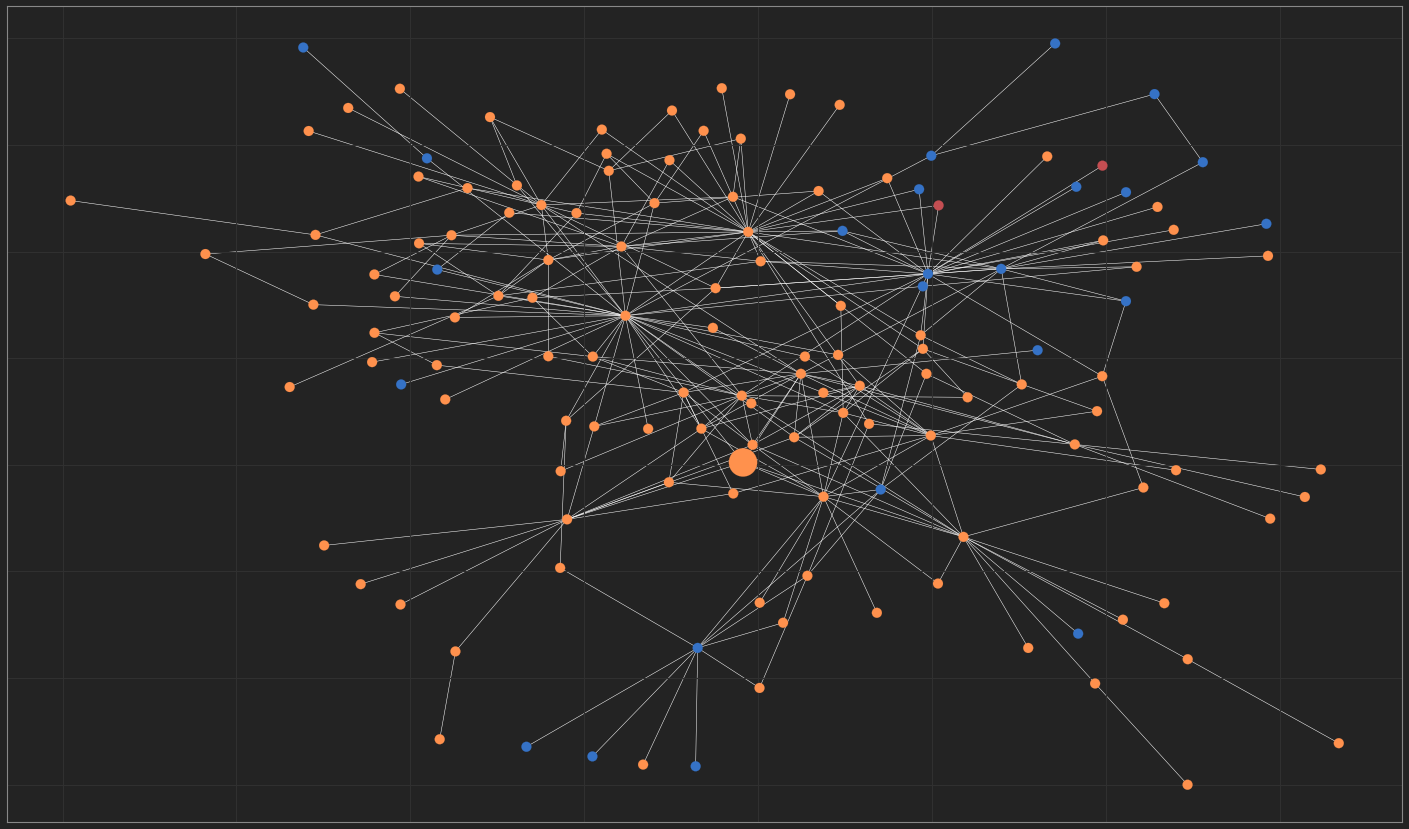

In [185]:
# 可视化采样子图结果
center_node = random.choices(list(train_G.nodes), k=1)  # 中心节点
n_nodes = [20, 10, 5]  # 每一阶采样邻居数
level = 3  # 多少阶的子图

search_list = [center_node]
center_nodes = list(search_list)[0]

for l in range(level):
    next_search_list = [i for x in search_list[l] for i in random.choices(
        list(train_G.neighbors(x)), k=n_nodes[l])]
    search_list.append(next_search_list)
    
sample_nodes = set([i for x in search_list for i in x])
sub_G = train_G.subgraph(sample_nodes)

plt.figure(figsize=(25, 15))
nx.draw_networkx(
    G=sub_G, 
    node_color=[c_map[x] for x inw df_paper.loc[list(sub_G.nodes), 'label'].values.tolist()],
    node_size=[100 if x not in center_nodes else 800 for x in list(sub_G.nodes)],
    with_labels=False,
    edge_color='w',
    width=0.5
)
plt.show()

## Batch Sampling

In [175]:
def sample_batch_node(graph, src_nodes, n_neighbor_list, node_features_tensor, nodes_label):
    
    # k 阶子图采样
    k_level_nodes = [src_nodes]
    
    for idx, n in enumerate(n_neighbor_list):
        next_level_nodes = []
        
        for node in k_level_nodes[idx]:
            next_level_nodes.extend(random.choices(list(graph.neighbors(node)), k=n))
        
        k_level_nodes.append(next_level_nodes)
    
    # 提取节点对应的 label
    labels = nodes_label[k_level_nodes[0]]
    
    # 转换成 tensor
    for i in range(len(k_level_nodes)):
        k_level_nodes[i] = node_features_tensor[k_level_nodes[i]]
    
    src_nodes = k_level_nodes[0]
    sample_nodes_list = k_level_nodes[1:]
    
    return src_nodes, sample_nodes_list, labels

In [193]:
# example
n_neighbor_list = [6, 6, 8]
node_features_tensor = torch.Tensor(df_paper[words].values)
nodes_label = torch.Tensor(df_paper['label'].values)

nodes = random.choices(list(train_G.nodes), k=128)

src_nodes, sample_nodes, labels = sample_batch_node(train_G, nodes, n_neighbor_list, node_features_tensor, nodes_label)

## DataLoader

In [320]:
# 自定义 Dataset 类
class MyDataSet(Dataset):
    def __init__(self, x):
        super().__init__()
        self.x = x

    def __getitem__(self, idx):
        return self.x[idx]

    def __len__(self):
        return len(self.x)

In [321]:
# 根据随机提取节点进行采样
def collate_fn(nodes):
    
    n_neighbor_list = config['n_neighbor_list']
    node_features_tensor = torch.Tensor(df_paper[words].values)
    nodes_label = torch.Tensor(df_paper['label'].values)
    
    src_nodes, sample_nodes, labels = sample_batch_node(train_G, nodes, n_neighbor_list, node_features_tensor, nodes_label)
    return (src_nodes, sample_nodes), labels

## Model

In [290]:
# 聚合卷积层
class AggregatorGCN(nn.Module):
    
    def __init__(self, in_dim, out_dim_list, n_neighbor_list):
        super(AggregatorGCN, self).__init__()
        assert len(out_dim_list) == len(n_neighbor_list)
        
        self.n_neighbor_list = n_neighbor_list
        self.n_layers = len(n_neighbor_list)
        
        self.relu = nn.ReLU()
        
        self.h_list = [in_dim] + out_dim_list
        self.fc_out_list = nn.ModuleList(
            [nn.Linear(self.h_list[x-1]*2, self.h_list[x]) for x in range(1, len(self.h_list))]
        )
        

    def forward(self, src_node_features, sample_features_list):
        
        # 构造完整方便迭代的数组结构
        hidden_features_list = [src_node_features] + sample_features_list
        
        # 共聚合 n_layers 层
        for n in range(self.n_layers):
            
            # 下一层聚合的结果
            new_nodes_features_list = []
            
            # 最外一层不需要聚合，所以减1
            for i in range(len(hidden_features_list)-1):
                
                # 源节点特征
                src_nodes_features = hidden_features_list[i]

                # 聚合源节点特征
                n_src_nodes = src_nodes_features.shape[0]
                agg_features_of_src = hidden_features_list[i+1].view(n_src_nodes, self.n_neighbor_list[i], -1).mean(dim=1)
                
                # 横向合并特征
                h_concat = torch.cat((src_nodes_features, agg_features_of_src), dim=1)
                
                # 线性转换与激活函数
                hidden = self.relu(self.fc_out_list[n](h_concat))
                
                new_nodes_features_list.append(hidden)

            # 更新下次需要迭代的列表
            hidden_features_list = new_nodes_features_list
        
        return new_nodes_features_list[0]

In [289]:
# 分类任务层
class GraphSAGE(nn.Module):
    def __init__(self, in_dim, out_dim_list, n_neighbor_list, n_class):
        super(GraphSAGE, self).__init__()
        self.agg = AggregatorGCN(in_dim, out_dim_list, n_neighbor_list)
        self.classifier = nn.Linear(out_dim_list[-1], n_class)


    def forward(self, x):
        h = self.agg(x[0], x[1])
        out = self.classifier(h)
        return out

# Training

## Training Model

In [336]:
class TrainModel(pl.LightningModule):
    def __init__(self, network):
        super(TrainModel, self).__init__()
        self.backbone = network
        self.loss = nn.CrossEntropyLoss()

    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self.backbone(x)
        loss = self.loss(output, y)
        self.log('Training Loss', loss)
        
        score = (output.max(dim=-1)[1] == y).sum() / len(output)
        self.log('Acc Score', score)
        return loss

#     def validation_step(self, batch, batch_idx):
#         x, y = batch
#         output = self.backbone(x)
#         loss = self.loss(output, y)
#         self.log('Validation Loss', loss)
#         return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters())
        return optimizer

    def forward(self, x):
        predict = self.backbone(x)
        return predict

## Training Flow

In [5]:
# 训练日志
tb_logger = pl_loggers.TensorBoardLogger('logs/')

# 加载 DataLoader
train_set = MyDataSet(list(train_G.nodes))
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, collate_fn=collate_fn)

# 模型定义
gcn = GraphSAGE(
    in_dim=confing['in_dim'], 
    out_dim_list=config['out_dim_list'],
    n_neighbor_list=config['n_neighbor_list'], 
    n_class=config['n_class']
)
model = TrainModel(gcn)

trainer = pl.Trainer(max_epochs=50, logger=tb_logger)
trainer.fit(model, train_loader)